# Spectroscopic overlap

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ November 1, 2022

This notebook serves as a testbed for calculating spectroscopic overlaps using mean field approximations for initial and final states and applying SRG transformations to the operator. The normalization of spectroscopic overlaps give relative spectroscopic factors. The first step is to compute the overlap of $^4\rm{He}$ with $^3\rm{H}$ and compare to [VMC calculations](https://www.phy.anl.gov/theory/research/overlaps/).

_Last update:_ November 1, 2022

__To-do list:__
* Check if you need the $(-i)^l$ factor in the Hankel transformation function. The factor may cancel out in all relevant formulas (like the overlap wave function).
* Correct $\delta U^\dagger_{\beta \gamma \alpha \gamma}$ term. It does not include $\beta > 1s_{1/2}$ currently. The other two $\alpha$ and $\gamma$ are fine.
* Problem with complex numbers.
* Update interpolation of $\delta U^\dagger$ to do coupled channels.
* Test sensitivity to interpolation settings of $\phi(k_i)$.
* Test sensitivity to interpolation settings of $\delta U^\dagger(k',k)$.
* Test sensitivity to `vegas` settings.
* Fix Clebsch-Gordan coefficients that give zero (either by avoiding combinations which give zero or making the table bigger).
* Sanity check by integrating over $k$, $k'$, and $K$ instead.
* Simplify single-particle notation.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
#from numpy.polynomial.legendre import leggauss
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn, sph_harm
from sympy.physics.quantum.cg import CG
import time
import vegas

In [2]:
# Imports from A.T. codes
from scripts.figures import set_rc_parameters, label_nucleus, label_sp_state
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
#from scripts.tools import find_index, replace_periods
from scripts.tools import coupled_channel, replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

# Load s.p. wave functions from the following directory
hfbrad_directory = '../data/dft/SLy4/'

## Functions

Move some of these functions into scripts at a later date.

In [5]:
def convert_l_to_string(l):
    """
    Returns the spectroscopic notation of the orbital angular momentum value
    l (e.g., l = 2 returns 'd').

    Parameters
    ----------
    l : int
        Orbital angular momentum of the single-particle (s.p.) state.

    Returns
    -------
    output : str
        Spectroscopic notation of s.p. state orbital angular momentum.

    """

    if l == 0:
        return 's'
    elif l == 1:
        return 'p'
    elif l == 2:
        return 'd'
    elif l == 3:
        return 'f'
    elif l == 4:
        return 'g'
    elif l == 5:
        return 'h'
    elif l == 6:
        return 'i'
    else:
        raise RuntimeError(
            "Input l value is outside the range of this function."
        )

In [6]:
def convert_l_to_int(sp_state):
    """
    Returns the orbital angular momentum given the s.p. state in spectroscopic 
    notation (e.g., '1d1p5' returns 2).

    Parameters
    ----------
    sp_state : str
        Spectroscopic notation of s.p. state (e.g., '1s0p5').

    Returns
    -------
    output : int
        Orbital angular momentum of the single-particle (s.p.) state.

    """
    
    if sp_state[1] == 's':
        return 0
    elif sp_state[1] == 'p':
        return 1       
    elif sp_state[1] == 'd':
        return 2
    elif sp_state[1] == 'f':
        return 3
    elif sp_state[1] == 'g':
        return 4
    elif sp_state[1] == 'h':
        return 5
    elif sp_state[1] == 'i':
        return 6
    else:
        raise RuntimeError(
            "Input s.p. state is outside the range of this function."
        )

In [7]:
def sp_states(nucleus_name, Z, N, print_info=False):
    """
    Return all the occupied single-particle states of the given nucleus.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'Ca40').
    Z : int
        Proton number.
    N : int
        Neutron number.
    print_statement : bool, optional
        Option to print information for each s.p. state in nucleus.
    
    Returns
    -------
    output : dict
        Dictionary with two keys: 'proton' and 'neutron'. Each corresponds to
        a list of all the occupied s.p. states, which are strings (e.g., '1s0p5'
        means 1s with j=1/2).
    
    Notes
    -----
    Currently we're assuming the SLy4 interaction.
    
    """

    # Go to HFBRAD directory
    densities_directory = f'../data/dft/SLy4/{nucleus_name}/'
    file_name = f'hfb_{N}_{Z}.spe'
    
    # Open file and add each occupied s.p. state to list
    neutron_states = []
    proton_states = []
    
    f = open(densities_directory + file_name, 'r')
    
    for line in f:
        
        unit = line.strip().split()  # Split up row into list
        
        # Make sure you're going through the correct data
        if (len(unit) == 12) and (unit[0] in ('1', '2')):
            
            # Only do occupied states:
            if float(unit[6]) == 1:
            
                # Integer specifying neutron or proton
                nucleon_number = unit[0]
        
                # j value
                j = int(unit[1])/2
        
                # Orbital angular momentum (int)
                l = int(unit[2])
                # Orbital angular momentum (str)
                l_str = convert_l_to_string(l)
        
                # Is this correct? (# of nodes)
                n = unit[11]
            
                # Convert s.p. state to string and append to list
                state_str = f'{n}{l_str}{j:.1f}'
            
                # Add string to neutron or proton list with periods replaced
                # by 'p'
                if nucleon_number == '1': # Neutron
                    neutron_states.append(replace_periods(state_str))
                elif nucleon_number == '2': # Proton
                    proton_states.append(replace_periods(state_str))
            
                # Print information for each state?
                if print_info:
                
                    info = (f"Nuc={nucleon_number}, N={unit[4]},"
                            f" state={state_str}")
                    print(info)
                
    f.close()
    
    return {'neutron' : neutron_states, 'proton' : proton_states}

In [8]:
def get_phi_rspace(nucleus_name, Z, N, nucleon, sp_state,
                   print_normalization=False):
    """Returns the single-particle wave function in coordinate space."""
    
    if nucleon == 'proton':
        nuc_int = 1
    elif nucleon == 'neutron':
        nuc_int = 0
    
    file_name = f'{nucleon}_{sp_state}_{N}_{Z}.gfx'
    
    data = np.loadtxt(hfbrad_directory + f"{nucleus_name}/wfs/{file_name}")

    r_array = data[:, 0]  # Units fm
    dr = r_array[1] - r_array[0]  # Linear spacing between r points
    phi_array = data[:, 2]  # Units fm^-1/2
    
    # These are normalized as \int dr |u(r)|^2 = 1
    if print_normalization:
        print(f"Normalization = {np.sum(dr*phi_array**2)}.")
    
    return r_array, phi_array

In [9]:
def plot_sp_wfs_rspace(nucleus_name, Z, N, x_limits=(0.0,10.0),
                       y_limits=(0.0,0.8), save=False):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        r_array, phi_array = get_phi_rspace(nucleus_name, Z, N, 'proton',
                                            sp_state)
        
        ax.plot(r_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"$u(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_rspace_SLy4.png'
        f.savefig(figures_directory + file_name)

In [10]:
def hankel_transformation(l, k_array, r_array, dr):
    """
    <k|r> transformation matrix for given orbital angular momentum l. If
    len(r_array) = m and len(k_array) = n, then this function returns an 
    n x m matrix.
    
    Parameters
    ----------
    l : int
        Orbital angular momentum.
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
    dr : float
        Coordinates step-size (weight) [fm].
        
    Returns
    -------
    M : 2-D ndarray
        Hankel transformation matrix [fm^3\2].
        
    Notes
    -----
    There is a "missing" factor of r in the transformation matrix since the
    radial wave functions are already multiplied by r, meaning the
    normalization is \int dr |u(r)|^2 = 1 without the r^2.

    """
    
    # r_array column vectors and k_array row vectors where both grids are
    # n x m matrices
    r_cols, k_rows = np.meshgrid(r_array, k_array)
        
    # M = (-1j)**l * np.sqrt(2/np.pi) * dr * r_cols * spherical_jn(l, k_rows * r_cols)
    M = np.sqrt(2/np.pi) * dr * r_cols * spherical_jn(l, k_rows * r_cols)

    return M

In [11]:
def get_phi_kspace(nucleus_name, Z, N, nucleon, sp_state,
                   print_normalization=False):
    """Returns the single-particle wave function in momentum space."""
    
    # Set momentum mesh
    k_array, k_weights = momentum_mesh(15.0, 3.0, 120)
    
    # Get coordinate-space s.p. wave function
    r_array, phi_r_array = get_phi_rspace(nucleus_name, Z, N, nucleon, sp_state)
    dr = r_array[2] - r_array[1]  # Assuming linear spacing in coordinates
    
    # Fourier-transform the wave function to momentum space
    l = convert_l_to_int(sp_state)
    phi_k_array = hankel_transformation(l, k_array, r_array, dr) @ phi_r_array
    
    # These are normalized as \int dk k^2 |\phi(k)|^2 = 1
    if print_normalization:
        print(f"Normalization = {np.sum(k_weights*k_array**2*phi_k_array**2)}.")

    return k_array, k_weights, phi_k_array

In [12]:
def plot_sp_wfs_kspace(nucleus_name, Z, N, x_limits=(0.0,5.0),
                       y_limits=(-0.1,4.0), save=False):
    """Plot the s.p. wave functions of a nucleus in momentum space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        k_array, _, phi_array = get_phi_kspace(nucleus_name, Z, N, 'proton',
                                               sp_state)
        
        ax.plot(k_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Add horizontal line at y=0
    ax.axhline(0.0, color='gray', alpha=0.4, zorder=1)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$\phi(k)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_kspace_SLy4.png'
        f.savefig(figures_directory + file_name)

In [13]:
def get_vmc_data(print_normalization=False):
    """Loads the VMC spectroscopic overlap."""
    
    file_name = "he4_overlap.txt"
    
    f = open(file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1]),
                float(unit[2].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    
    if print_normalization:
        q_array = data[:,0]
        dq = q_array[2]-q_array[1]
        overlap_array = data[:,1]
        print(1/(2*np.pi)**3*np.sum(dq*q_array**2*overlap_array**2))
    
    return data

In [14]:
def interpolate_phi_kspace(nucleus_name, Z, N, nucleon, sp_state):
    """Interpolate s.p. wave functions \phi(k)."""
    
    k_array, _, phi_array = get_phi_kspace(nucleus_name, Z, N, nucleon,
                                           sp_state)

    # Interpolate s.p. wave functions
    phi_func = interp1d(k_array, phi_array, kind='linear', bounds_error=False,
                        fill_value='extrapolate')
    ### TESTING
#     phi_func = interp1d(k_array, phi_array, kind='linear', bounds_error=True)

    return phi_func

In [15]:
def interpolate_deltaU_dagger(kvnn, channel, lamb, kmax, kmid, ntot, generator):
    """Interpolate \delta U^\dagger(k',k)."""

    # Set potential
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    
    # Get momentum mesh
    k_array, k_weights = potential.load_mesh()
    
    # Initial and evolved Hamiltonians
    H_initial = potential.load_hamiltonian()
    if generator == 'Block-diag':
        H_evolved = potential.load_hamiltonian('srg', generator, 1.0,
                                               lambda_bd=lamb)
    else:
        H_evolved = potential.load_hamiltonian('srg', generator, lamb)
    
    # Get SRG transformation from Hamiltonians
    U_matrix_weights = get_transformation(H_initial, H_evolved)[:ntot,:ntot]

    # Calculate \delta U^\dagger = (U - I)^\dagger
    I_matrix_weights = np.eye(ntot, ntot)
    delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T
    delUdag_matrix = unattach_weights_from_matrix(k_array, k_weights,
                                                  delUdag_matrix_weights)
    
    # Interpolate \delta U^\dagger(k,k')
    delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix, kx=1,
                                       ky=1)
    ### TESTING
#     delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix)

    return delUdag_func

In [16]:
def compute_cg_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for all combinations of j and m_j
    up to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j values.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients < j_1 m_j_1 j_2 m_j_2 | j_3 m_j_3 >
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)

    for j_1 in j_array:
        for m_1 in np.arange(-j_1, j_1+1, 1):
            for j_2 in j_array:
                for m_2 in np.arange(-j_2, j_2+1, 1):
                    for j_3 in j_array:
                        for m_3 in np.arange(-j_3, j_3+1, 1):
                            cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                            )
                                
    return cg_table

In [17]:
def get_sp_quantum_numbers(sp_state):
    """Gets the single-particle quantum numbers of a state."""
    
    # Principal quantum number n = 1, 2, 3, ...
    n = int(sp_state[0])
    
    # Orbital angular momentum l = 0, 1, 2, ...
    if sp_state[1] == 's':
        l = 0
    elif sp_state[1] == 'p':
        l = 1
    elif sp_state[1] == 'd':
        l = 2
    elif sp_state[1] == 'f':
        l = 3
    elif sp_state[1] == 'g':
        l = 4
    elif sp_state[1] == 'h':
        l = 5
    else:
        raise RuntimeError(
            "Single-particle state l exceeds the range of the function."
        )
    
    # Total angular momentum j = 1/2, 3/2, 5/2, ...
    j_str = sp_state[2:]
    j = float(j_str[0] + '.' + j_str[-1])
        
    return n, l, j

In [18]:
def get_sp_state(n, l, j, tau):
    """Spectroscopic notation of the single-particle state and nucleon."""
    
    l_str = convert_l_to_string(l)
    j_str = replace_periods(str(j))
    sp_state = f'{n}{l_str}{j_str}'
    
    if tau == 1/2:
        nucleon = 'proton'
    elif tau == -1/2:
        nucleon = 'neutron'
    else:
        raise RuntimeError("tau must be +1/2 or -1/2.")
    
    return sp_state, nucleon

In [19]:
def get_channel_quantum_numbers(channel):
    """Gets the quantum numbers of a partial wave channel."""
    
    # Total orbital angular momentum L' = 0, 1, 2, ...
    if channel[1] == 'S':
        Lp = 0
    elif channel[1] == 'P':
        Lp = 1
    elif channel[1] == 'D':
        Lp = 2
    elif channel[1] == 'F':
        Lp = 3
    elif channel[1] == 'G':
        Lp = 4
    elif channel[1] == 'H':
        Lp = 5
    else:
        raise RuntimeError("Channel L' exceeds the range of the function.")
    
    # Total orbital angular momentum L = 0, 1, 2, ...
    # L = L' if the channel is not coupled
    if coupled_channel(channel[:3]):
        
        if channel[5] == 'S':
            L = 0
        elif channel[5] == 'P':
            L = 1
        elif channel[5] == 'D':
            L = 2
        elif channel[5] == 'F':
            L = 3
        elif channel[5] == 'G':
            L = 4
        elif channel[5] == 'H':
            L = 5
        else:
            raise RuntimeError("Channel L exceeds the range of the function.")
            
    else:
        
        L = Lp
        
    # Total spin S = 0 or 1
    S = int((int(channel[0])-1)/2)
    
    # Total angular momentum J = 0, 1, 2, ...
    J = int(channel[2])
            
    return Lp, L, S, J

In [20]:
def get_total_isospin(L, S):
    """Total isospin according to antisymmetry of matrix element."""
    
    # Make sure [1-(-1)^(L+S+T)] is not zero
    if (1-(-1)**(L+S)) == 0:
        T = 1
    else:
        T = 0
        
    return T

In [21]:
# Note, you will want to make set-up part of an __init__ method and call
# attributes since this function relies on many
def delta_U_dagger_integrand(alpha, beta, gamma, delta, x):
    """Integrand of the specified \delta U^\dagger matrix element."""
    
    # Get s.p. quantum numbers
    n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha = alpha
    n_beta, l_beta, j_beta, m_j_beta, tau_beta = beta
    n_gamma, l_gamma, j_gamma, m_j_gamma, tau_gamma = gamma
    n_delta, l_delta, j_delta, m_j_delta, tau_delta = delta
    
    # Set range of m_l values
    m_l_alphas = np.intersect1d(np.arange(-l_alpha, l_alpha+1, 1),
                                m_j_alpha - spins)
    m_l_betas = np.intersect1d(np.arange(-l_beta, l_beta+1, 1),
                                m_j_beta - spins)
    m_l_gammas = np.intersect1d(np.arange(-l_gamma, l_gamma+1, 1),
                                m_j_gamma - spins)
    m_l_deltas = np.intersect1d(np.arange(-l_delta, l_delta+1, 1),
                                m_j_delta - spins)
    
    # Single-particle momenta
    k1, theta1, phi1 = x[:3]
    k1_vector = np.array([k1 * np.sin(theta1) * np.cos(phi1),
                          k1 * np.sin(theta1) * np.sin(phi1),
                          k1 * np.cos(theta1)])
        
    k2, theta2, phi2 = x[3:6]
    k2_vector = np.array([k2 * np.sin(theta2) * np.cos(phi2),
                          k2 * np.sin(theta2) * np.sin(phi2),
                          k2 * np.cos(theta2)])
        
    k3, theta3, phi3 = x[6:]
    k3_vector = np.array([k3 * np.sin(theta3) * np.cos(phi3),
                          k3 * np.sin(theta3) * np.sin(phi3),
                          k3 * np.cos(theta3)])
    
    # Compute k_4 vector and each of its components
    k4_vector = k1_vector + k2_vector - k3_vector
    k4 = la.norm(k4_vector)
    theta4 = np.arccos(k4_vector[2]/k4)
    phi4 = np.arctan2(k4_vector[1], k4_vector[0])
        
    # Compute k' vector and each of its components
    kp_vector = (k1_vector-k2_vector)/2
    kp = la.norm(kp_vector)
    thetap = np.arccos(kp_vector[2]/kp)
    phip = np.arctan2(kp_vector[1], kp_vector[0])
        
    # Compute k vector and each of its components
    k_vector = (k3_vector-k4_vector)/2
    k = la.norm(k_vector)
    theta = np.arccos(k_vector[2]/k)
    phi = np.arctan2(k_vector[1], k_vector[0])
        
    # Calculate the Jacobian determinant
    jacobian = (k1**2 * np.sin(theta1) * k2**2 * np.sin(theta2) * k3**2 
                * np.sin(theta3))
    
    # Calculate single-particle wave functions \phi(k)
    alpha_sn, nucleon_alpha = get_sp_state(n_alpha, l_alpha, j_alpha, tau_alpha)
    beta_sn, nucleon_beta = get_sp_state(n_beta, l_beta, j_beta, tau_beta)
    gamma_sn, nucleon_gamma = get_sp_state(n_gamma, l_gamma, j_gamma, tau_gamma)
    delta_sn, nucleon_delta = get_sp_state(n_delta, l_delta, j_delta, tau_delta)
    
    phi_alpha = phi_functions[nucleon_alpha][alpha_sn](k1)
    phi_beta = phi_functions[nucleon_beta][beta_sn](k2)
    phi_gamma = phi_functions[nucleon_gamma][gamma_sn](k3)
    phi_delta = phi_functions[nucleon_delta][delta_sn](k4)
    
    # Initialize integrand
    integrand = 0
    ### TESTING
    # integrand = 0+0j

    # Loop over channels
    for channel in channels:
    
        # Determine L', L, S, J, T
        Lp, L, S, J = get_channel_quantum_numbers(channel)
        T = get_total_isospin(L, S)
        
        # Compute 1-(-1)^(L'+S+T) and 1-(-1)^(L+S+T) factors
        factor = (1-(-1)**(Lp+S+T)) * (1-(-1)**(L+S+T))
        
        # Calculate \delta U^\dagger(k', k)
        delta_U_dagger = delta_U_dagger_functions[channel].ev(kp, k)
    
        # Possible M_J values
        total_angular_momentum_projections = np.arange(-J, J+1, 1)
        
        # Possible M_L values
        total_orbital_angular_momentum_projections = np.arange(-L, L+1, 1)
        
        # Total isospin is fixed by \tau's
        M_T = tau_alpha + tau_beta
        if abs(M_T) > T:
            isospin_cg_alpha_beta = 0
            isospin_cg_gamma_delta = 0
        else:
            # Calculate < \tau_\alpha \tau_\beta | T M_T >
            isospin_cg_alpha_beta = cg_table[(0.5, tau_alpha, 0.5, tau_beta, T,
                                              M_T)]
        
            # Calculate < T M_T | \tau_\gamma \tau_\delta >
            isospin_cg_gamma_delta = cg_table[(0.5, tau_gamma, 0.5, tau_delta, T,
                                               M_T)]
        
        # Loop over m_l_\alpha, calculate Y, \sigma, and CG
        for m_l_alpha in m_l_alphas:

            Y_alpha = sph_harm(m_l_alpha, l_alpha, phi1, theta1)
                    
            sigma_alpha = m_j_alpha - m_l_alpha
                    
            alpha_cg = cg_table[(
                l_alpha, m_l_alpha, 1/2, sigma_alpha, j_alpha, m_j_alpha
            )]
            
            # Loop over m_l_\beta, calculate Y, \sigma, and CG
            for m_l_beta in m_l_betas:

                Y_beta = sph_harm(m_l_beta, l_beta, phi2, theta2)
                    
                sigma_beta = m_j_beta - m_l_beta
                    
                beta_cg = cg_table[(
                    l_beta, m_l_beta, 1/2, sigma_beta, j_beta, m_j_beta
                )]
                
                # Compute total spin projection
                M_S = sigma_alpha + sigma_beta
                
                # Calculate < 1/2 \sigma_\alpha 1/2 \sigma_\beta | S M_S >
                if abs(M_S) > S:
                    spin_cg_alpha_beta = 0
                else:
                    spin_cg_alpha_beta = cg_table[(
                        1/2, sigma_alpha, 1/2, sigma_beta, S, M_S
                    )]
                
                # Loop over m_l_\gamma, calculate Y, \sigma, and CG
                for m_l_gamma in m_l_gammas:

                    Y_gamma = sph_harm(m_l_gamma, l_gamma, phi3, theta3)
                    
                    sigma_gamma = m_j_gamma - m_l_gamma
                    
                    gamma_cg = cg_table[(
                        l_gamma, m_l_gamma, 1/2, sigma_gamma, j_gamma, m_j_gamma
                    )]
                    
                    # Loop over m_l_\delta, calculate Y, \sigma, and CG
                    for m_l_delta in m_l_deltas:

                        Y_delta = sph_harm(m_l_delta, l_delta, phi4, theta4)
                    
                        sigma_delta = m_j_delta - m_l_delta
                    
                        delta_cg = cg_table[(
                            l_delta, m_l_delta, 1/2, sigma_delta, j_delta,
                            m_j_delta
                        )]
                        
                        # Calculate < S M_S | 1/2 \sigma_\gamma 1/2 \sigma_\delta >
                        if abs(M_S) > S:
                            spin_cg_gamma_delta = 0
                        else:
                            spin_cg_gamma_delta = cg_table[(
                                1/2, sigma_gamma, 1/2, sigma_delta, S, M_S
                            )]
                        
                        # Loop over M_J and M_L, and set M_L' = M_L
                        for M_J in total_angular_momentum_projections:
                            for M_L in total_orbital_angular_momentum_projections:
                                
                                M_Lp = M_L
                                
                                # Compute Y_{L' M_L'}(k')
                                Y_Lp = sph_harm(M_Lp, Lp, phip, thetap)
                                
                                # Compute Y_{L M_L}(k)
                                Y_L = sph_harm(M_L, L, phi, theta)
                                
                                # Calculate < L' M_L' S M_S | J M_J >
                                if abs(M_S) > S:
                                    Lp_S_J_cg = 0
                                else:
                                    Lp_S_J_cg = cg_table[(Lp, M_Lp, S, M_S, J,
                                                          M_J)]
                                
                                # Calculate < J M_J | L M_L S M_S >
                                if abs(M_S) > S:
                                    L_S_J_cg = 0
                                else:
                                    L_S_J_cg = cg_table[(L, M_L, S, M_S, J,
                                                         M_J)]
                                
                                # Add contribution to integrand
                                integrand += 1/2 * (
                                    alpha_cg * beta_cg * gamma_cg * delta_cg
                                    * phi_alpha * phi_beta * phi_gamma * phi_delta
                                    * Y_alpha * Y_beta * Y_gamma * Y_delta * Y_Lp * Y_L
                                    * spin_cg_alpha_beta * spin_cg_gamma_delta
                                    * isospin_cg_alpha_beta * isospin_cg_gamma_delta
                                    * Lp_S_J_cg * L_S_J_cg * factor
                                    * delta_U_dagger * jacobian
                                )
                                
    return integrand

In [22]:
def compute_delta_U_dagger(alpha, beta, gamma, delta):
    """Compute the specified matrix element of \delta U^\dagger."""
    
    # Check that isospin works
    if alpha[-1] + beta[-1] != gamma[-1] + delta[-1]:
        return 0
    
    ### TESTING
    t0 = time.time()
        
    # Compute integrations over k1, k2, and k3 vectors
    k_limits = [0, 10]
    theta_limits = [0, np.pi]
    phi_limits = [0, 2*np.pi]
    integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                              k_limits, theta_limits, phi_limits,
                              k_limits, theta_limits, phi_limits])
    
    # Set function for vegas
    integrand = lambda x: delta_U_dagger_integrand(alpha, beta, gamma, delta, x)

    result = integ(integrand, nitn=10, neval=1e4)
    ### TESTING
    # result = integ(integrand, nitn=10, neval=1e5)

    ### TESTING
    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done after {mins} minutes.")
    print(alpha, beta, gamma, delta)
        
    # TESTING
    print(result.summary())
    print(result)
    print(result.mean)
    print(result.sdev)

    return result.mean

In [23]:
def compute_spectroscopic_overlap(alpha):
    """Compute the spectroscopic overlap of the given nucleus and s.p. state."""
    
    # Initialize momenta q and its angles
    q_array, q_weights = gaussian_quadrature_mesh(10.0, 120)

    # \theta_q goes from 0 to \pi
    theta_q_array, theta_q_weights = gaussian_quadrature_mesh(np.pi, 7)
        
    # \phi_q goes from 0 to 2\pi
    phi_q_array, phi_q_weights = gaussian_quadrature_mesh(2*np.pi, 11)
        
    # Create meshgrids for q_vector and integration over d\theta_q and d\phi_q
    q_grid, theta_grid, phi_grid = np.meshgrid(q_array, theta_q_array,
                                               phi_q_array, indexing='ij')
    _, dtheta_grid, dphi_grid = np.meshgrid(
        q_array, np.sin(theta_q_array) * theta_q_weights, phi_q_weights,
        indexing='ij'
    )
    
    # Get s.p. quantum numbers
    n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha = alpha
    ### TESTING
    tau_beta = tau_alpha
    
    # Set range of m_l values
    m_l_alphas = np.intersect1d(np.arange(-l_alpha, l_alpha+1, 1),
                                m_j_alpha - spins)
    
    # Get nucleon and spectroscopic notation of the state \alpha
    alpha_sn, nucleon_alpha = get_sp_state(n_alpha, l_alpha, j_alpha, tau_alpha)
    
    # I term
    I_grid = np.zeros_like(q_grid, dtype='complex')
    
    # Calculate \phi_\alpha(q)
    phi_alpha_grid = phi_alpha_function(q_grid)
    
    for m_l_alpha in m_l_alphas:
        
        # Calculate Y_{l_\alpha m_l_\alpha}(q)
        Y_alpha_grid = sph_harm(m_l_alpha, l_alpha, phi_grid, theta_grid)
        
        # Calculate \sigma_\alpha
        sigma_alpha = m_j_alpha - m_l_alpha
        
        # Calculate \alpha CG
        alpha_cg = cg_table[(l_alpha, m_l_alpha, 1/2, sigma_alpha, j_alpha,
                             m_j_alpha)]
        
        I_grid += phi_alpha_grid * Y_alpha_grid * alpha_cg

    # \delta U^\dagger term
    delta_U_dagger_grid = np.zeros_like(q_grid, dtype='complex')
#     for nucleon_beta in ['proton', 'neutron']:
        
#         if nucleon_beta == 'proton':
#             tau_beta = 1/2
#         else:
#             tau_beta = -1/2
    if tau_beta == 1/2:
        nucleon_beta = 'proton'
    else:
        nucleon_beta = 'neutron'
        
    # Sum over \beta is unrestricted
    for beta in betas[nucleon_beta]:
            
        n_beta, l_beta, j_beta = get_sp_quantum_numbers(beta)
            
        # Get spectroscopic notation of the state \beta
        beta_sn, _ = get_sp_state(n_alpha, l_alpha, j_alpha, tau_alpha)
            
        # Calculate \phi_\beta(q)
        phi_beta_grid = phi_functions[nucleon_beta][beta_sn](q_grid)
            
        for m_j_beta in np.arange(-j_beta, j_beta+1, 1):
                
            # Set range of m_l values
            m_l_betas = np.intersect1d(np.arange(-l_beta, l_beta+1, 1),
                                       m_j_beta - spins)
                
            for nucleon_gamma in ['proton', 'neutron']:
        
                if nucleon_gamma == 'proton':
                    tau_gamma = 1/2
                else:
                    tau_gamma = -1/2
                
                # Sum over \gamma is restricted to states < F
                for gamma in gammas[nucleon_gamma]:
                        
                    n_gamma, l_gamma, j_gamma = get_sp_quantum_numbers(gamma)
                        
                    for m_j_gamma in np.arange(-j_gamma, j_gamma+1, 1):
                
                        # Calculate \delta U^\dagger_{\beta \gamma \alpha \gamma}
                        delta_U_dagger = compute_delta_U_dagger(
                            (n_beta, l_beta, j_beta, m_j_beta, tau_beta),
                            (n_gamma, l_gamma, j_gamma, m_j_gamma, tau_gamma),
                            (n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha),
                            (n_gamma, l_gamma, j_gamma, m_j_gamma, tau_gamma)
                        )
            
                        for m_l_beta in m_l_betas:
                    
                            # Calculate Y_{l_\beta m_l_\beta}(q)
                            Y_beta_grid = sph_harm(m_l_beta, l_beta, phi_grid,
                                                   theta_grid)
        
                            # Calculate \sigma_\beta
                            sigma_beta = m_j_beta - m_l_beta
        
                            # Calculate \beta CG
                            beta_cg = cg_table[(l_beta, m_l_beta, 1/2,
                                                sigma_beta, j_beta, m_j_beta)]
                                
                            delta_U_dagger_grid += (phi_beta_grid * Y_beta_grid
                                                    * beta_cg * delta_U_dagger)
                        
    # Integrate over \theta_q and \phi_q
    integrand = (I_grid + delta_U_dagger_grid) * dtheta_grid * dphi_grid
    overlap_array = np.sum(np.sum(integrand, axis=-1), axis=-1)
    
    return q_array, q_weights, overlap_array

In [24]:
def plot_spectroscopic_overlap(
        q_array, q_weights, overlap_array, x_limits=(0.0,10.0),
        y_limits=(1e-5,1e2), y_scale='log', show_vmc=False, save=False):
    """Plot the spectrosopic overlap as a function of momentum q."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    ### TESTING
    # factor = np.sqrt(4 * np.pi * 2 * (2*np.pi)**3)
    factor = np.sqrt(2 * (2*np.pi)**3 / (4*np.pi))
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Compare to VMC calculation?
    if show_vmc:
        data = get_vmc_data()
        q_array_vmc = data[:,0]
        overlap_array_vmc = data[:,1]
        ax.plot(q_array_vmc, abs(overlap_array_vmc), label='VMC', linewidth=2.0)
    
    # Take absolute value
    ax.plot(q_array, abs(overlap_array)*factor, label=label_sp_state('1s0p5'),
            linewidth=2.0)
    
    ### TESTING
    print(1/(2*np.pi)**3*np.sum(q_weights*q_array**2*overlap_array**2*factor**2))

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_overlap_{kvnn}_{lamb}_SLy4.png'
        f.savefig(figures_directory + file_name)

In [42]:
def compute_spectroscopic_factor(q_array, q_weights, overlap_array):
    
    return np.sum(q_weights * q_array**2 * abs(overlap_array)**2)/(4*np.pi)

## Single-particle wave functions in coordinate space

In [26]:
nucleus_name, Z, N = 'He4', 2, 2

In [27]:
phi_r_array = get_phi_rspace(nucleus_name, Z, N, 'proton', '1s0p5',
                             print_normalization=True)

Normalization = 1.0000000007365384.


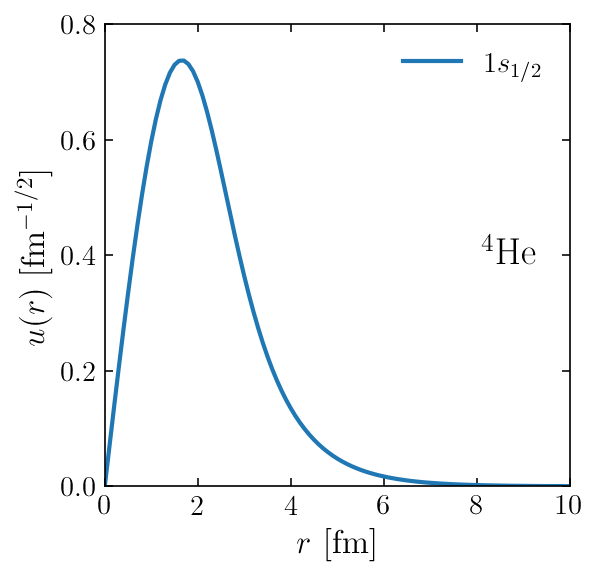

In [28]:
plot_sp_wfs_rspace(nucleus_name, Z, N, save=True)

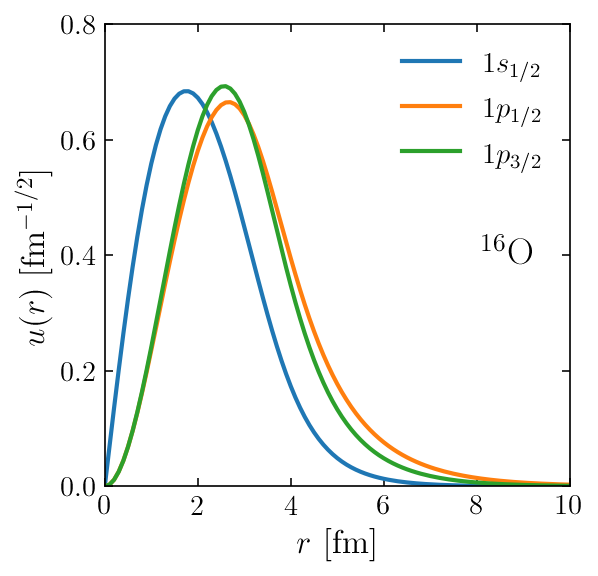

In [29]:
plot_sp_wfs_rspace('O16', 8, 8, save=True)

## Single-particle wave functions in momentum space

In [30]:
k_array, k_weights, phi_k_array = get_phi_kspace(
    nucleus_name, Z, N, 'proton', '1s0p5', print_normalization=True
)

Normalization = 1.0000000007365952.


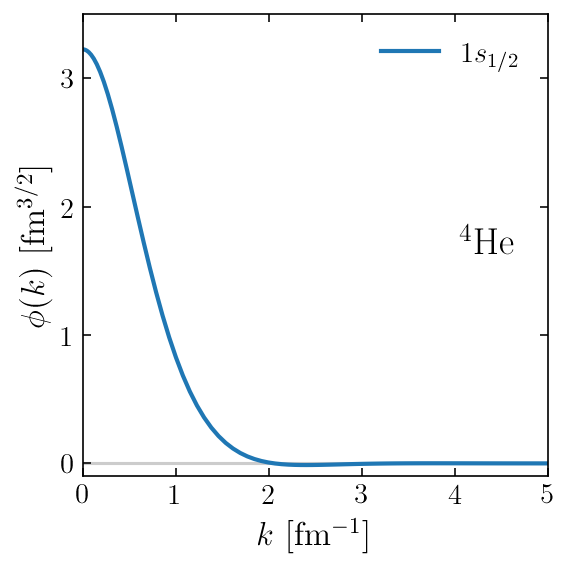

In [31]:
plot_sp_wfs_kspace(nucleus_name, Z, N, y_limits=(-0.1,3.5), save=True)

## Spectroscopic overlaps

In [32]:
# VMC normalization
data = get_vmc_data(print_normalization=True)

1.6221510359897304


### Set-up for calculation

In [33]:
# Nucleus to calculate
nucleus_name, Z, N = 'He4', 2, 2

In [34]:
# Potential and SRG evolution
kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
channels = ('1S0', '3S1-3S1')
lamb = 1.35
generator = 'Wegner'

In [35]:
# Set arrays for quantum numbers
spins = np.array([1/2, -1/2])
isospins = spins
total_spins = np.array([1, 0, -1])
gammas = sp_states('He4', 2, 2)
betas = gammas  # This should go beyond F for the general case

In [36]:
# Set interpolating functions for s.p. wave functions \phi
phi_functions = {}
phi_functions['proton'] = {}
for beta in betas['proton']:
    phi_functions['proton'][beta] = interpolate_phi_kspace(nucleus_name, Z, N,
                                                           'proton', beta)
phi_functions['neutron'] = {}
for beta in betas['neutron']:
    phi_functions['neutron'][beta] = interpolate_phi_kspace(nucleus_name, Z, N,
                                                            'neutron', beta)

In [37]:
# Set interpolating functions for \delta U^\dagger
delta_U_dagger_functions = {}
for channel in channels:
    delta_U_dagger_functions[channel] = interpolate_deltaU_dagger(
        kvnn, channel[:3], lamb, kmax, kmid, ntot, generator
    )

In [38]:
# Calculate all possible Clebsch-Gordan coefficients up to (including) j = 3
cg_table = compute_cg_table(3)

In [39]:
# Calculate spectroscopic overlap for \alpha = 1s_{1/2} proton
alpha = (1, 0, 1/2, 1/2, 1/2)
alpha_sn, nucleon_alpha = get_sp_state(alpha[0], alpha[1], alpha[2], alpha[-1])
phi_alpha_function = interpolate_phi_kspace(nucleus_name, Z, N, nucleon_alpha,
                                            alpha_sn)
q_array, q_weights, overlap_array = compute_spectroscopic_overlap(alpha)

/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_27779/2518569343.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  result = integ(integrand, nitn=10, neval=1e4)


Done after 0.14385446707407634 minutes.
(1, 0, 0.5, -0.5, 0.5) (1, 0, 0.5, -0.5, 0.5) (1, 0, 0.5, 0.5, 0.5) (1, 0, 0.5, -0.5, 0.5)
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0(0)            0.0(3.2)e-129       0.00     1.00
  2   0(0)            0.0(2.2)e-129       0.00      nan
  3   0(0)            0.0(1.8)e-129       0.00      nan
  4   0(0)            0.0(1.6)e-129       0.00      nan
  5   0(0)            0.0(1.4)e-129       0.00      nan
  6   0(0)            0.0(1.3)e-129       0.00      nan
  7   0(0)            0.0(1.2)e-129       0.00      nan
  8   0(0)            0.0(1.1)e-129       0.00      nan
  9   0(0)            0.0(1.1)e-129       0.00      nan
 10   0(0)            0.0(1.0)e-129       0.00      nan

0.0(1.0)e-129
0.0
1.0000000000000001e-129
Done after 0.1476224144299825 minutes.
(1, 0, 0.5, -0.5, 0.5) (1, 0, 0.5, 0.5, 0.5) (1, 0, 0.5, 0.5, 0.5) (1, 0, 0.5, 0.5, 0.5)
itn   integral        wgt 

(1.7439095771350712+0j)


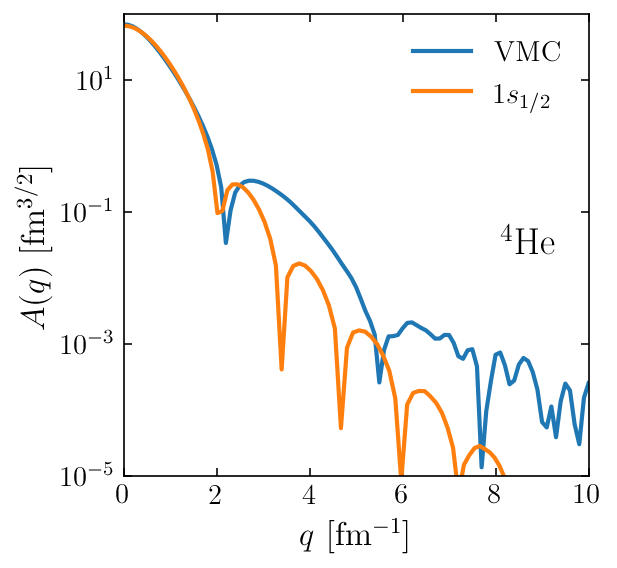

In [40]:
plot_spectroscopic_overlap(q_array, q_weights, overlap_array, show_vmc=True)

In [44]:
2*compute_spectroscopic_factor(q_array, q_weights, overlap_array)

1.7439095771350708